>>>***Preparation of python libraries***
















In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')


from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Bidirectional
from math import sqrt


import seaborn as sns
import scipy
from numpy import *
import keras.backend as K
from keras.regularizers import l2

>>>***INPUT DATA PROCESSING***




---



valores nulos GOLDMONEY    0
dtype: int64


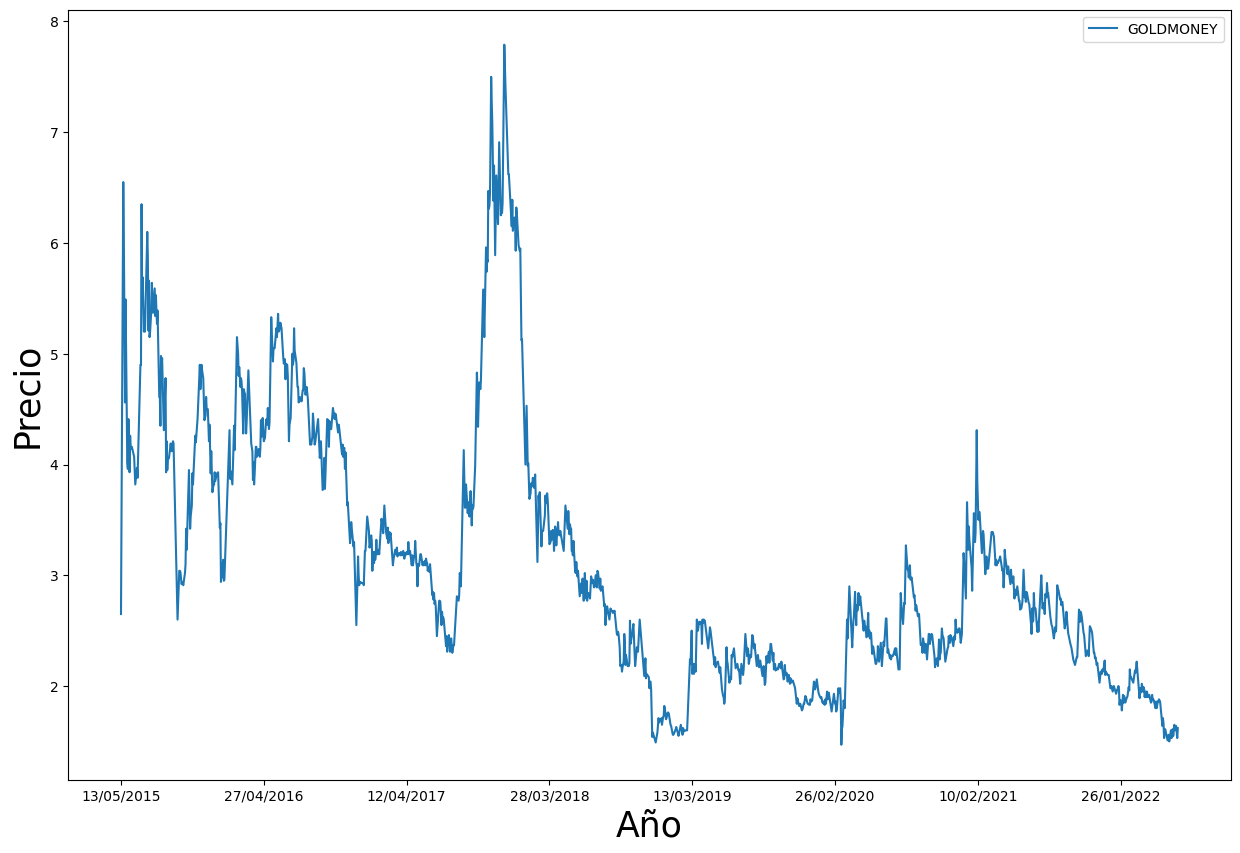

In [ ]:
df = pd.read_csv('Name_of_the_file', index_col='Date')
valores_nulos = df.isnull().sum()
df = df.dropna()
df.head() #Dataframe characteristics are shown
#Chart parameters are defined, such as index labels, chart size, etc.
df.plot(figsize=(15,10))
plt.legend(fontsize=10)
plt.xlabel('Year', fontsize=25)
plt.ylabel('Price',fontsize=25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

***The code is divided into train (80%: 70% for training and 10% for validation) and test (20)***

In [ ]:
v=int(len(df))
values = df.iloc[:v,-1].values
values = values.astype('float32')
values=values.reshape(-1, 1)
n_train_days = int(len(df)*0.7)
n_val_days=int(len(df)*0.1)
n_test_days=int(len(df)*0.2)
train = values[:n_train_days-n_val_days, :]
validation= train[:n_val_days, :]
test = values[n_train_days:, :]
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]


***Data normalization***

In [ ]:
dataframe1=df.transpose()
train_rate = 0.8 #Training rate will determine the learning level of the network
seq_len = 25 #It will use a window of 25 data to make the prediction
pre_len = 5 #It will launch 25 predictions for each of the time windows used
num_nodes, time_len = dataframe1.shape
#Data is normalized between [0,1]
def train_test_split(data, train_portion):
    time_len = data.shape[1]
    train_size = int(time_len * train_portion)
    train_data = np.array(data.iloc[:1, :n_train_days-n_val_days])
    test_data = np.array(data.iloc[:1, n_train_days:])
    val_data =  np.array(data.iloc[:1, n_train_days-n_val_days:n_train_days])
    return train_data, test_data,val_data
train_data, test_data, val_data = train_test_split(dataframe1, train_rate)
def scale_data(train_data, test_data,val_data):
    max_speed = train_data.max()
    min_speed = train_data.min()
    train_scaled = (train_data - min_speed) / (max_speed - min_speed)
    test_scaled = (test_data - min_speed) / (max_speed - min_speed)
    val_scaled = (val_data - min_speed) / (max_speed - min_speed)
    return train_scaled, test_scaled,val_scaled
train_scaled, test_scaled, val_scaled = scale_data(train_data, test_data,val_data)
def sequence_data_preparation(seq_len, pre_len, train_data, test_data,val_data):
    trainX, trainY, testX, testY, valY, valX = [], [], [], [], [], []

    for i in range(train_data.shape[1] - int(seq_len + pre_len - 1)):
        a = train_data[:, i : i + seq_len + pre_len]
        trainX.append(a[:, :seq_len])
        trainY.append(a[:, -1])

    for i in range(test_data.shape[1] - int(seq_len + pre_len - 1)):
        b = test_data[:, i : i + seq_len + pre_len]
        testX.append(b[:, :seq_len])
        testY.append(b[:, -1])

    for i in range(val_data.shape[1] - int(seq_len + pre_len - 1)):
        c = val_data[:, i : i + seq_len + pre_len]
        valX.append(c[:, :seq_len])
        valY.append(c[:, -1])

    trainX = np.array(trainX)
    trainY = np.array(trainY)
    testX = np.array(testX)
    testY = np.array(testY)
    valX = np.array(valX)
    valY = np.array(valY)

    return trainX, trainY, testX, testY, valX, valY
trainX, trainY, testX, testY, valX, valY = sequence_data_preparation(
    seq_len, pre_len, train_scaled, test_scaled, val_scaled
)

>>>***MODEL GENERATION***

In [ ]:
def crear_modeloFF():
    model = Sequential()
    PASOS=25
    model.add(Bidirectional(LSTM(50, return_sequences = False, activation='tanh')))
    model.add(Flatten())
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

EPOCHS=100
PASOS=25
model = crear_modeloFF()

from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=120,
        verbose=1, mode='auto', restore_best_weights=True)

history=model.fit(trainX,trainY,epochs=EPOCHS,callbacks=[monitor],validation_data=(valX,valY),batch_size=PASOS)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 50)             15200     
                                                                 
 bidirectional_3 (Bidirecti  (None, 100)               40400     
 onal)                                                           
                                                                 
 flatten_3 (Flatten)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 20)                2020      
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                                 
Total params: 57641 (225.16 KB)
Trainable params: 57641 (225.16 KB)
Non-trainable params: 0 (0.00 Byte)
________________

***The results are rescaled and the graph is displayed***

Test RMSE: 0.240
Test MSE: 0.058
% RMSE
0.19656529405813636
         real  prediccion  diferencia
0    0.939746    1.002865   -0.063119
1    1.075762    0.938752    0.137009
2    0.939746    0.911720    0.028026
3    0.902651    0.924169   -0.021519
4    1.038667    0.933698    0.104969
..        ...         ...         ...
522  0.148381    0.164278   -0.015897
523  0.185476    0.149490    0.035986
524  0.086556    0.176875   -0.090320
525  0.049460    0.220468   -0.171008
526  0.160746    0.187809   -0.027063

[527 rows x 3 columns]
otra
23.628402907176795
R2
0.8364640424889778


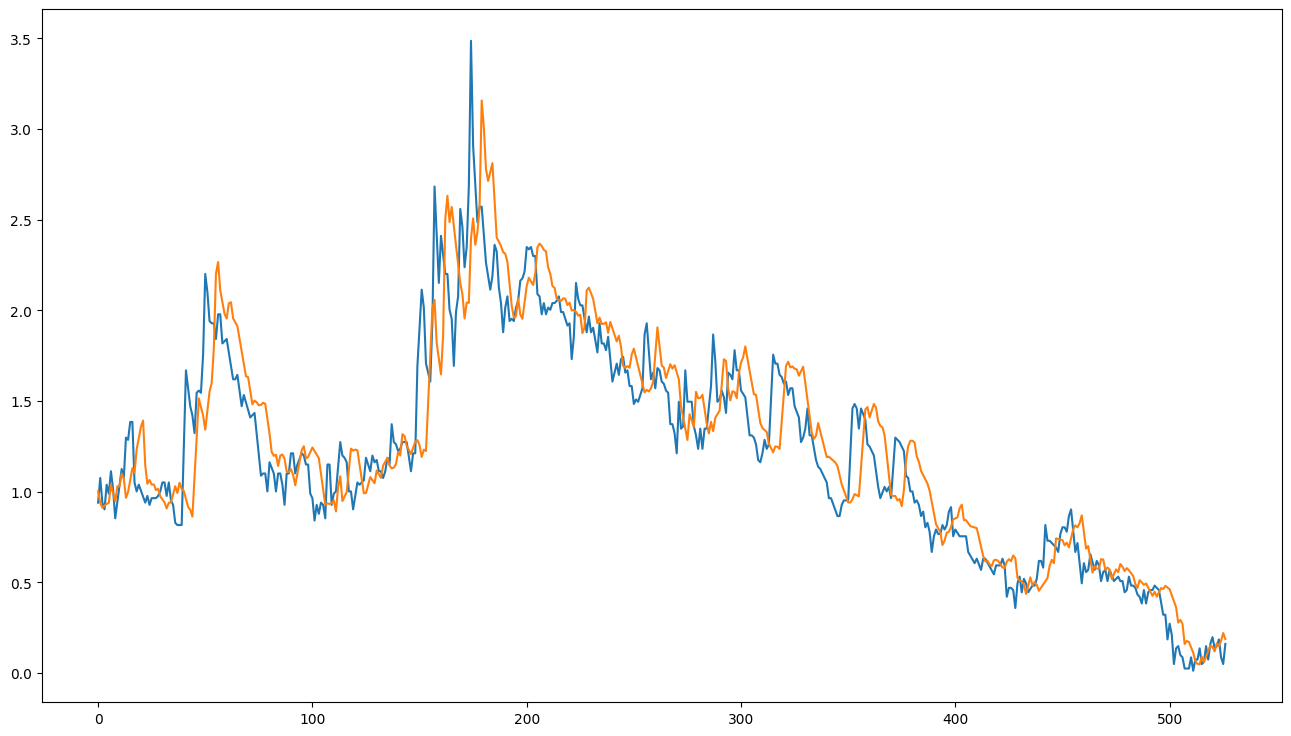

In [ ]:

df2 = pd.DataFrame(results)

max_speed = train_data.max()
min_speed = train_data.min()
train_rescpred = np.array((testY) * max_speed)
pred = np.array((results) * max_speed)
pcompara = pd.DataFrame(np.array([[y[0] for y in train_rescpred], [x[0] for x in pred]])).transpose()


pcompara.columns = ['real', 'prediccion']
pcompara['diferencia'] = pcompara['real'] - pcompara['prediccion']
pcompara.head()
pcompara['real'].plot()
pcompara['prediccion'].plot()
#Results are saved in a CSV
pcompara.to_csv('Name_of_the_file')

